## 5.4	Creating Real Time Defenses
### 5.4.3	Generating fake images for CNN training example

#### LOADING THE LIBRARIES

In [1]:
# Import the required libraries.
import tensorflow as tf
import os
import time
from matplotlib import pyplot as plt
from IPython import display

#### GETTING THE DATASETS
You can use this code to obtain the datasets if you don't have them already. This particular dataset contains training, verification, and testing versons of building facades (fronts). The reason to use this particular dataset is that it's easily available and you can find other examples that use it for comparison purposes.

In [2]:
URL = 'https://people.eecs.berkeley.edu/~tinghuiz/' + \
      'projects/pix2pix/datasets/facades.tar.gz'

ZIP_Path = tf.keras.utils.get_file('facades.tar.gz', origin=URL, extract=True)

PATH = os.path.join(os.path.dirname(ZIP_Path), 'facades/')
print(PATH)

C:\Users\John\.keras\datasets\facades/


#### SEEING THE IMAGES
It's important to know how the images are put together. In this case, you have pairings of input and real images to work with. The input image appears on the left of the JPEG, while the real image appears on the right. So, a single image file is actually 512 pixels wide and 256 pixels high, but the individual images are 256 x 256.

Text(0.5, 1.0, 'Real Image')

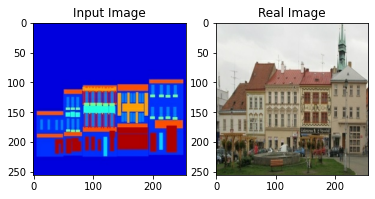

In [3]:
# Specify the parameters for using the images. Each image
# file actually contains two 256 X 256 images, an input
# image and a real image. The input image is actually just
# an outline of sorts.
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Define a method for loading images into memory from
# the dataset.
def load(image_file):
    raw_image = tf.io.read_file(image_file)
    decode_image = tf.image.decode_jpeg(raw_image)

    shape = tf.shape(decode_image)[1]
    shape = shape // 2
    image1 = decode_image[:, :shape, :]
    image2 = decode_image[:, shape:, :]

    real_image = tf.cast(image1, tf.float32)
    input_image = tf.cast(image2, tf.float32)

    return input_image, real_image

# Separate the two images from the sngle image file.
input_image, real_image = load(PATH+'train/40.jpg')

# Cast the input images to int values for MatPlotLib.
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(input_image/255.0)
axes[0].set_title("Input Image")
axes[1].imshow(real_image/255.0)
axes[1].set_title("Real Image")

#### MANIPULATING THE IMAGES
If you kept the images precisely the same, the model would never really learn about small image differences. The following code performs tasks like making the images slightly larger and then cropping random areas of the result so that the result would be a subset of the original. By adding these subsets together, what you get is a jitter, a kind of shakiness between images.

Using `tf.image.resize()` with a resize `method=tf.image.ResizeMethod.NEAREST_NEIGHBOR` produces an output type of `images`, rather than `float32`. The images type in this case is a 3D tensor of shape `[height, width, channels]`. Consequently, when you see that the images are treated as 256 x 256 x 3 later in the code, what that's really referring to is the `images` type.

In [4]:
# Define functions for manipulating the images in various ways.
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

@tf.autograph.experimental.do_not_convert
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]

@tf.function()
def random_jitter(input_image, real_image):
    # resizing to 286 x 286 x 3
    input_image, real_image = resize(input_image, real_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    input_image, real_image = random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # random mirroring
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

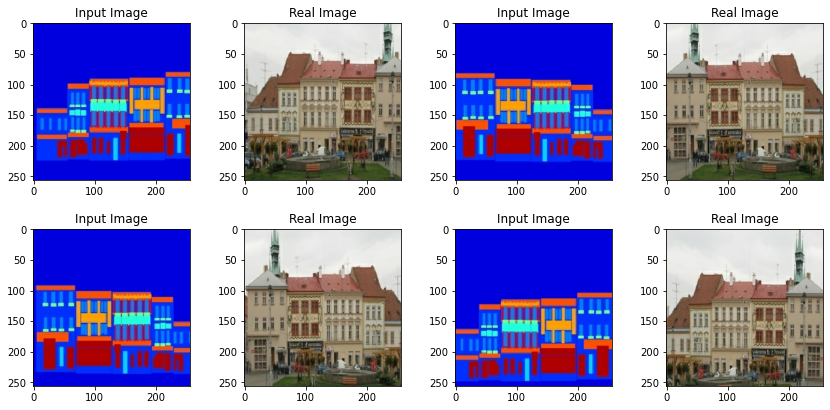

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
fig.tight_layout(pad=2)
for i in range(2):
    for j in range(0, 4):
        if j%2 == 0:
            changed_input_image, changed_real_image = \
                random_jitter(input_image, real_image)
            axes[i, j].imshow(changed_input_image/255.0)
            axes[i, j].set_title("Input Image")
            axes[i, j + 1].imshow(changed_real_image/255.0)
            axes[i, j + 1].set_title("Real Image")

It's important to normalize the images to keep wide variances between them from affecting the final result. This normalization process sets the value for each tensor between -1 and 1. Consequently, when you see the output after normalization, what you see is an `images` tensor of shape `[height, width, channels]`.

In [6]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

normal_input_image, normal_real_image = normalize(input_image, real_image)
print(normal_input_image)

tf.Tensor(
[[[-0.94509804 -0.9529412   0.34901965]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 [[-0.94509804 -0.9529412   0.34901965]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 [[-0.94509804 -0.9529412   0.34901965]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]]

 ...

 [[-0.94509804 -0.9529412   0.32549024]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  ...
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.7411765 ]
  [-1.         -1.          0.741

#### LOADING THE DATASETS
The initial section that follows provides code for actually loading the individual image files from the training and testing folders. The training images have jitter applied to better train the model. The testing images are specifically resized to ensure they're uniform and the correct size for the test. In both cases, the data is normalized.

The second section actually performs the task of loading the images into either a `train_dataset` or a `test_dataset`. The example loads only half of the training set to keep the training time shorter. Otherwise, you might need to wait for a really long time for the training to complete on a computer without GPU support. If you really want to see the effect of the entire training set, change `BUFFER_SIZE` to `400`. Just one copy of the files are loaded. To ensure that training isn't inhibited by an sequential pictures, the training dataset is shuffled.

In [7]:
# Load the training image files, apply random jitter to them, 
# then normalize them.
@tf.autograph.experimental.do_not_convert
def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

# Load the testing image files, resize them to 256 X 256,
# then normalize them.
@tf.autograph.experimental.do_not_convert
def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image,
                                     IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)

    return input_image, real_image

In [8]:
# Allow enough space for half the training set and
# create just one batch.
BUFFER_SIZE = 200
BATCH_SIZE = 1

# Create the training dataset using all of the training images.
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
val_dataset = tf.data.Dataset.list_files(PATH+'val/*.jpg')
train_dataset = train_dataset.concatenate(val_dataset)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=4)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

# Create the testing dataset using all of the testing images.
test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

# The result of the loading process is a TensorFlow BatchDataset
# that you can iterate using the following code.
features, label = iter(train_dataset).next()
print("example features:", features[0])
print("example label:", label[0])

example features: tf.Tensor(
[[[-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  ...
  [-0.99215686 -0.6313726   0.99215686]
  [-0.9843137  -0.6313726   0.99215686]
  [-0.9607843  -0.64705884  0.99215686]]

 [[-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  ...
  [-1.         -0.6313726   0.9843137 ]
  [-1.         -0.6392157   0.9843137 ]
  [-0.96862745 -0.6392157   0.99215686]]

 [[-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  ...
  [-1.         -0.6313726   0.99215686]
  [-1.         -0.6313726   0.99215686]
  [-0.9843137  -0.6313726   0.99215686]]

 ...

 [[-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  [-1.         -1.          0.73333335]
  ...
  [-1.         -0.58431375  0.92941177]
  [-1.         -0.6392157   0.9607843 ]
  [-0.9843137  

#### CREATING THE GENERATOR
A GAN relies on a discriminator and a generator working against each other in an adversarial setting to output the best possible version of a data element, such as an image. Each cycle improves either the discriminator model or the generator model. This first section creates the generator model, but it isn't complete without the generator. This generator design is a modified U-Net (https://paperswithcode.com/method/u-net), which relies on encoding and decoding of the image data. The example uses a different layer arrangement than specified in the source website based on experimentation. You can find other layer layouts in other examples online.

In [9]:
OUTPUT_CHANNELS = 3

def downsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())

    return result

down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_image, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [10]:
def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.ReLU())

    return result

up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Create the left side of the U by decreasing the image resolution
    # and compressing it.
    down_stack = [
        downsample(64, 4),   # Multi-Channel Feature Map =  128, 128, 64
        downsample(128, 4),  # Multi-Channel Feature Map =  64, 64, 128
        downsample(256, 4),  # Multi-Channel Feature Map =  32, 32, 256
        downsample(512, 4),  # Multi-Channel Feature Map =  16, 16, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  8, 8, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  4, 4, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  2, 2, 512
        downsample(512, 4),  # Multi-Channel Feature Map =  1, 1, 512
    ]

    # Create the right side of the U by increasing the image resolution
    # and decompressing it.
    up_stack = [
        upsample(512, 4),    # Multi-Channel Feature Map =  2, 2, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  4, 4, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  8, 8, 1024
        upsample(512, 4),    # Multi-Channel Feature Map =  16, 16, 1024
        upsample(256, 4),    # Multi-Channel Feature Map =  32, 32, 512
        upsample(128, 4),    # Multi-Channel Feature Map =  64, 64, 256
        upsample(64, 4),     # Multi-Channel Feature Map =  128, 128, 128
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    # Multi-Channel Feature Map =  256, 256, 3)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                           padding='same',
                                           kernel_initializer=initializer,
                                           activation='tanh')

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

#### DEFINING THE GENERATOR LOSS FUNCTION
The loss function determines the difference between the input image and the real image. The purpose of this function is to quantify the difference between the two so that the generated output can come closer to the real image using a *Mean Absolute Error (MAE)* calculation.

In [12]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss


#### CREATING THE DISCRIMINATOR
The discriminator looks at what the generator has created and determines whether it's real or fake. When the discriminator is correct and the image is fake, the generator is tweaked to create a better fake image. The generator model is based on a PatchGAN (https://paperswithcode.com/method/patchgan).

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')


    # Multi-Channel Feature Map =  256, 256, channels*2)
    x = tf.keras.layers.concatenate([inp, tar])

    down1 = downsample(64, 4)(x)       # Multi-Channel Feature Map =  128, 128, 64
    down2 = downsample(128, 4)(down1)  # Multi-Channel Feature Map =  64, 64, 128
    down3 = downsample(256, 4)(down2)  # Multi-Channel Feature Map =  32, 32, 256

    # Multi-Channel Feature Map =  34, 34, 256
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    
    # Multi-Channel Feature Map =  31, 31, 512
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Multi-Channel Feature Map =  33, 33, 512
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  

    # Multi-Channel Feature Map =  30, 30, 1
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2)  

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator()

#### DEFINING THE DISCRIMINATOR LOSS
The loss function helps the discriminator detect whether an image is real or fake. It's a three step process that begins by obtaining the `real_loss`, which is a comparison of the real images to an array of ones using sigmoid cross entropy loss. The second step is to obtain the `generated_loss`, which is a comparison of the generated images to an array of zeroes using sigmoid cross entropy loss. The final step is to add the `real_loss` to the `generated_loss` to obtain the total loss.

In [14]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

#### PERFORMING OPTIMIZATION OF BOTH GENERATOR AND DISCRIMINATOR 
This code relies on the optimization before you can compile it. The following code is based on the discussion at https://keras.io/api/optimizers/.

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### MONITORING THE TRAINING PROCESS
The `generate_images()` function makes a prediction based on the current model, then outputs the result on screen so that you can monitor the progress of the training process. The code outputs the input image, the real image (known as the ground truth, and what the model will output as a result of its training (the predicted image).

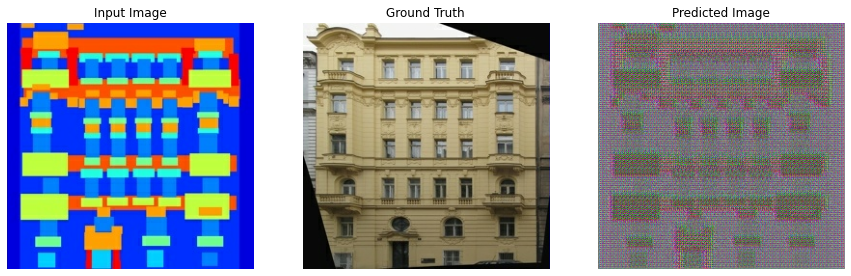

In [16]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

for example_input, example_target in test_dataset.take(1):
    generate_images(generator, example_input, example_target)

#### TRAINING THE MODEL
It's finally time to train the model. The following code takes everything you've created so far and uses it to train the model by placing the generator and discriminator submodels in an adversarial state. The example only uses 25 epochs to keep model training time low, while showing a useful, but not stellar, result. You typically use in excess of 100 epochs to train a model for production use. The `train_step()` function describes what to do for each step of the model training, while the `fit()` function performs the actual task of fitting the model to the data.

In [17]:
EPOCHS = 24

@tf.function
@tf.autograph.experimental.do_not_convert
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute the amount to change the model after each training cycle.
    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    # Apply the changes to the model, optimizing the result.
    generator_refittings = 3
    for _ in range(generator_refittings):
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                            discriminator.trainable_variables))

In [18]:
def fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        display.clear_output(wait=True)

        for example_input, example_target in test_ds.take(1):
            generate_images(generator, example_input, example_target)

        print("Epoch: ", epoch)

        # Train
        for n, (input_image, target) in train_ds.enumerate():
            print('.', end='')
            if (n+1) % 100 == 0:
                print()
            train_step(input_image, target, epoch)
        print()

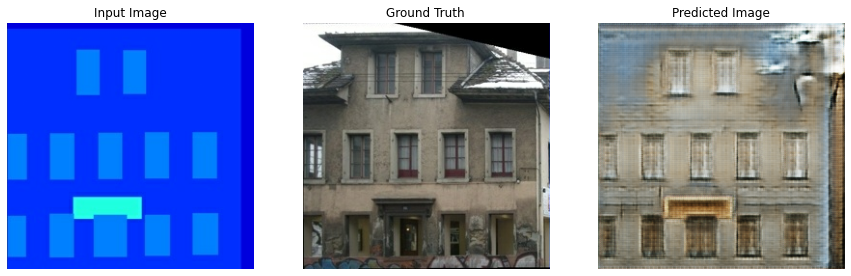

Epoch:  23
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................



In [19]:
%load_ext tensorboard

fit(train_dataset, EPOCHS, test_dataset)

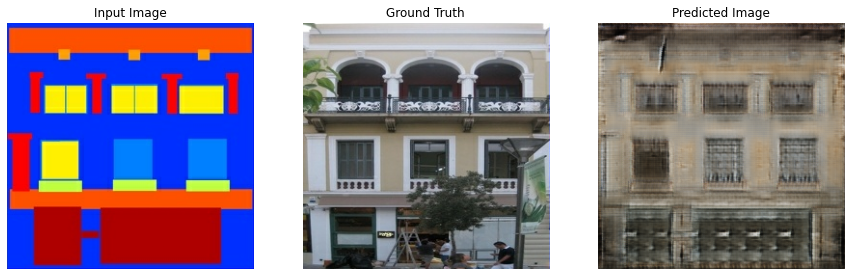

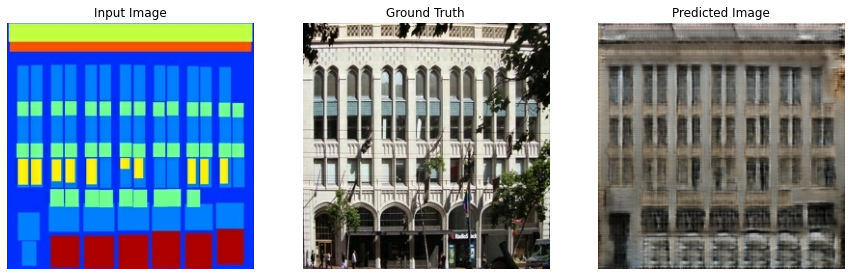

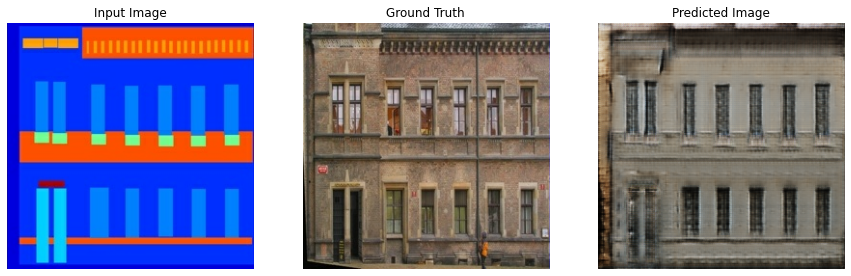

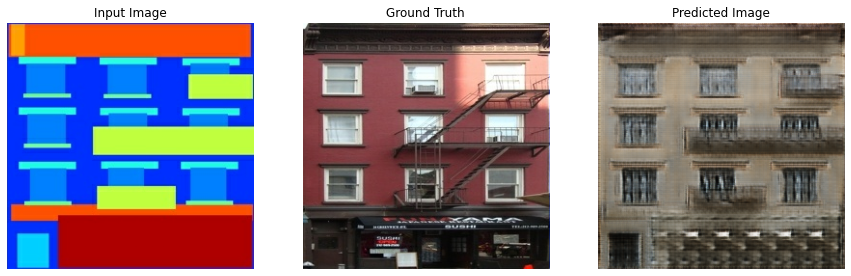

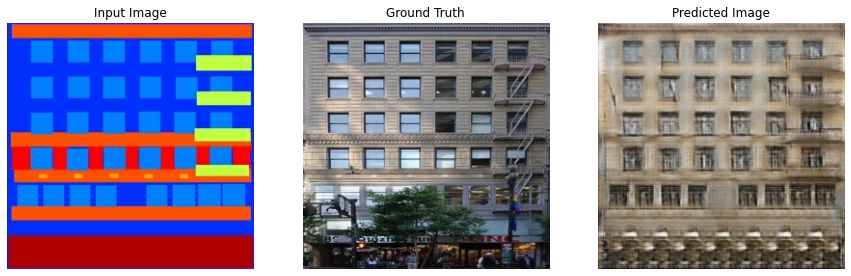

In [20]:
for example_input, example_target in test_dataset.take(5):
    generate_images(generator, example_input, example_target)